In [3]:
#!pip install pyodbc
import pandas as pd
import numpy as np
import pyodbc

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV

# en cas de besoin 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder,StandardScaler,MinMaxScaler

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer,ColumnTransformer

In [25]:
#***********************************************************************************************************************
# this code is for designing Silver layer by reading tables from bronze layer and making cleansing and transforming data
# I will not use any transformation in this step ,  i will use bronze layer as backup
#***********************************************************************************************************************
# Connnection to the database 
def connect_database():
    server = 'E6K-VDI1601\\TFTIC'   
    database = 'DataWarehouse_Demo'
    username = 'sa'
    password = 'tftic@2012'
    driver = '{ODBC Driver 17 for SQL Server}'    
    conn=pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}' ,  autocommit=True)
    cursor = conn.cursor()
    return cursor , conn

In [26]:
# call the function connect_database and get cursor and connection
cur , con = connect_database()

In [27]:
# Read the customers table from sql server
query = "select * from bronze.crm_customers ;"
df_customers = pd.read_sql(query, con)

# Display the DataFrame
df_customers.head()

C:\Users\b.azreg\AppData\Local\Temp\ipykernel_14796\1716421256.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql(query, con)


,cst_id,cst_key,cst_firstname,cst_lastname,cst_marital_status,cst_gndr,cst_create_date
0,11000,AW00011000,Jon,Yang,M,M,2025-10-06
1,11001,AW00011001,Eugene,Huang,S,M,2025-10-06
2,11002,AW00011002,Ruben,Torres,M,M,2025-10-06
3,11003,AW00011003,Christy,Zhu,S,F,2025-10-06
4,11004,AW00011004,Elizabeth,Johnson,S,F,2025-10-06


In [28]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cst_id              9999 non-null   int64         
 1   cst_key             9999 non-null   object        
 2   cst_firstname       9999 non-null   object        
 3   cst_lastname        9999 non-null   object        
 4   cst_marital_status  9999 non-null   object        
 5   cst_gndr            9999 non-null   object        
 6   cst_create_date     9999 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 546.9+ KB


In [29]:
# check if cst_id is unique
print(df_customers['cst_id'].duplicated().sum())

0


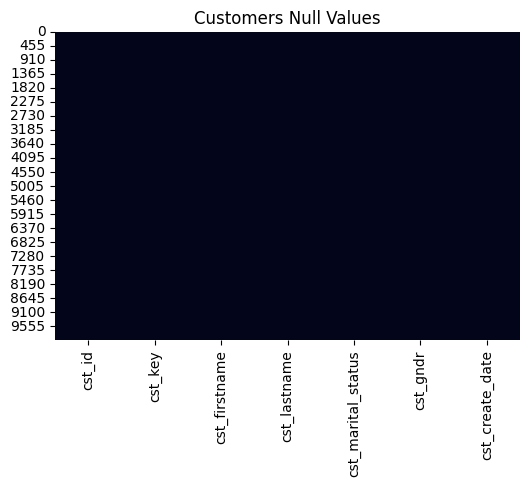

In [30]:
# check if there is any null value in the dataset  
plt.figure(figsize=(6,4))
plt.title('Customers Null Values')
sns.heatmap(df_customers.isna(),cbar=False)
plt.show()

In [32]:
# check for unwanted spaces for firstname 

df_customers[df_customers['cst_firstname'].str.contains(' ',regex=False)==True]

,cst_id,cst_key,cst_firstname,cst_lastname,cst_marital_status,cst_gndr,cst_create_date
0,11000,AW00011000,Jon,Yang,M,M,2025-10-06
4,11004,AW00011004,Elizabeth,Johnson,S,F,2025-10-06
12,11012,AW00011012,Lauren,Walker,M,F,2025-10-06
13,11013,AW00011013,Ian,Jenkins,M,M,2025-10-06
15,11015,AW00011015,Chloe,Young,S,F,2025-10-06
21,11021,AW00011021,Destiny,Wilson,S,F,2025-10-07
63,11063,AW00011063,Angela,Murphy,S,F,2025-10-07
65,11065,AW00011065,Jessica,Henderson,M,F,2025-10-07
67,11067,AW00011067,Caleb,Carter,S,M,2025-10-07
70,11070,AW00011070,Willie,Raji,M,M,2025-10-07


In [33]:
# delete unwanted left and rigth spaces from cst_firstname
df_customers['cst_firstname'] = df_customers['cst_firstname'].str.strip()

In [34]:
# verify no unwanted space in cst_firstname
df_customers[df_customers['cst_firstname'].str.contains(' ',regex=False)==True]

,cst_id,cst_key,cst_firstname,cst_lastname,cst_marital_status,cst_gndr,cst_create_date
9164,20164,AW00020164,Carol Ann,Rockne,M,M,2026-01-05


In [35]:
# delete unwanted left and rigth spaces from cst_lastname
df_customers['cst_lastname']=df_customers['cst_lastname'].str.strip()

In [36]:
# verify no unwanted space in cst_lastname
df_customers[df_customers['cst_lastname'].str.contains(' ',regex=False)==True]

,cst_id,cst_key,cst_firstname,cst_lastname,cst_marital_status,cst_gndr,cst_create_date
9497,20497,AW00020497,Francisco,Javier CastrejÇün,M,F,2026-01-05


In [37]:
# check  for null value in cst_marital_status column
df_customers['cst_marital_status'].isnull().sum()

np.int64(0)

In [38]:
# check how many distinct values in cst_marital_status
df_customers['cst_marital_status'].unique()

array(['M', 'S'], dtype=object)

In [39]:
# Replace S by : Single and M : by Married
df_customers['cst_marital_status']=df_customers['cst_marital_status'].replace('S','Single')
df_customers['cst_marital_status']=df_customers['cst_marital_status'].replace('M','Married')

In [40]:
# verify the cst_marital_status
df_customers['cst_marital_status'].unique()

array(['Married', 'Single'], dtype=object)

In [41]:
# check distinct values in cst_gndr
df_customers['cst_gndr'].unique()

array(['M', 'F', ''], dtype=object)

In [42]:
# replace abreviation M, F by 'Male' and 'Female'
df_customers['cst_gndr'] = df_customers['cst_gndr'].replace('M','Male')
df_customers['cst_gndr'] = df_customers['cst_gndr'].replace('F', 'Female')
df_customers['cst_gndr'] = df_customers['cst_gndr'].replace('' ,'None')

In [43]:
# Verify cst_gndr values
df_customers['cst_gndr'].unique()

array(['Male', 'Female', 'None'], dtype=object)

In [44]:
df_customers['cst_gndr']=df_customers['cst_gndr'].str.strip()

In [45]:
df_customers.head(3)

,cst_id,cst_key,cst_firstname,cst_lastname,cst_marital_status,cst_gndr,cst_create_date
0,11000,AW00011000,Jon,Yang,Married,Male,2025-10-06
1,11001,AW00011001,Eugene,Huang,Single,Male,2025-10-06
2,11002,AW00011002,Ruben,Torres,Married,Male,2025-10-06


In [46]:
# truncate table before insert any record
cur.execute(' truncate table  silver.crm_customers ;')
# sql for insert df_customers into silver.crm_customers
silver_crm_customer_insert="""use DataWarehouse_Demo ; INSERT INTO silver.crm_customers (
    cst_id ,
    cst_key ,
    cst_firstname ,
    cst_lastname ,
    cst_marital_status ,
    cst_gndr ,
    cst_create_date 
    )  
    values(?,?,?,?,?,?,?)
"""

In [47]:
try:
    for i , row in df_customers.iterrows():
        cur.execute(silver_crm_customer_insert,list(row))
        con.commit()
    print("Rows inserted successfully !")
except:
    print("Error to insert rows")
finally:
    con.close()
    print('database connecction closed')

Rows inserted successfully !
database connecction closed


In [102]:
# Read the products table from sql server
cur,con = connect_database()
query = "select * from bronze.crm_products ;"
df_products = pd.read_sql(query, con)

# Display the DataFrame
df_products

C:\Users\b.azreg\AppData\Local\Temp\ipykernel_14796\2466955132.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_products = pd.read_sql(query, con)


,prd_id,prd_key,prd_nm,prd_cost,prd_line,prd_start_dt,prd_end_dt
0,210,CO-RF-FR-R92B-58,HL Road Frame - Black- 58,0,R,2003-07-01,1899-12-30
1,211,CO-RF-FR-R92R-58,HL Road Frame - Red- 58,0,R,2003-07-01,1899-12-30
2,212,AC-HE-HL-U509-R,Sport-100 Helmet- Red,12,S,2011-07-01,2007-12-28
3,213,AC-HE-HL-U509-R,Sport-100 Helmet- Red,14,S,2012-07-01,2008-12-27
4,214,AC-HE-HL-U509-R,Sport-100 Helmet- Red,13,S,2013-07-01,1899-12-30
...,...,...,...,...,...,...,...
392,602,CO-BB-BB-8107,ML Bottom Bracket,45,,2013-07-01,1899-12-30
393,603,CO-BB-BB-9108,HL Bottom Bracket,54,,2013-07-01,1899-12-30
394,604,BI-RB-BK-R19B-44,Road-750 Black- 44,344,R,2013-07-01,1899-12-30
395,605,BI-RB-BK-R19B-48,Road-750 Black- 48,344,R,2013-07-01,1899-12-30


In [103]:
# check if prd_id_key is unique
print(df_products['prd_id'].duplicated().sum())

0


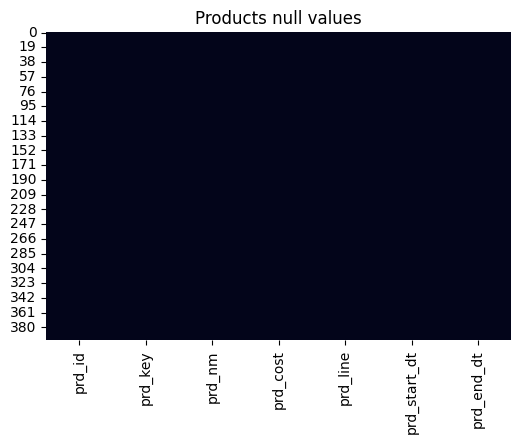

In [104]:
plt.figure(figsize=(6,4))
plt.title('Products null values')
sns.heatmap(df_products.isna(),cbar=False)
plt.show()


In [105]:
df_products.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   prd_id        397 non-null    int64         
 1   prd_key       397 non-null    object        
 2   prd_nm        397 non-null    object        
 3   prd_cost      397 non-null    int64         
 4   prd_line      397 non-null    object        
 5   prd_start_dt  397 non-null    datetime64[ns]
 6   prd_end_dt    397 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 21.8+ KB


In [106]:

# --------- I have  to split prd_key into ( cat_id : first 4 caracters and prd_key the reminders characters
# --------  the original prd_key will receive the chracters from 6th 

df_products['cat_id'] = df_products['prd_key'].str[:5]
# in bronze.erp_category the cat_id column has underscore instead of dash, so we have to replaced
df_products['cat_id'] = df_products['cat_id'].replace('-', '_', regex=True)
df_products['prd_key'] = df_products['prd_key'].str[6:]
df_products.head()

,prd_id,prd_key,prd_nm,prd_cost,prd_line,prd_start_dt,prd_end_dt,cat_id
0,210,FR-R92B-58,HL Road Frame - Black- 58,0,R,2003-07-01,1899-12-30,CO_RF
1,211,FR-R92R-58,HL Road Frame - Red- 58,0,R,2003-07-01,1899-12-30,CO_RF
2,212,HL-U509-R,Sport-100 Helmet- Red,12,S,2011-07-01,2007-12-28,AC_HE
3,213,HL-U509-R,Sport-100 Helmet- Red,14,S,2012-07-01,2008-12-27,AC_HE
4,214,HL-U509-R,Sport-100 Helmet- Red,13,S,2013-07-01,1899-12-30,AC_HE


In [108]:
# check if prd_cost is negative
df_products[df_products['prd_cost'] < 0]

,prd_id,prd_key,prd_nm,prd_cost,prd_line,prd_start_dt,prd_end_dt,cat_id


In [109]:
print(df_products['prd_cost'].isna().sum())

0


In [110]:
# check distinct values of prd_line column
df_products['prd_line'].unique()

array(['R ', 'S ', 'M ', '', 'T '], dtype=object)

In [111]:
# delete left and rigth spaces
df_products['prd_line'] = df_products['prd_line'].str.strip()

In [112]:
df_products['prd_line'].unique()

array(['R', 'S', 'M', '', 'T'], dtype=object)

In [113]:
# replace abreviation M, S  , R , T 
df_products['prd_line']=df_products['prd_line'].replace('M','Mountain')
df_products['prd_line']=df_products['prd_line'].replace('S','Sport')
df_products['prd_line']=df_products['prd_line'].replace('T','Touring')
df_products['prd_line']=df_products['prd_line'].replace('R','Road')
df_products['prd_line']=df_products['prd_line'].replace('','None')

In [114]:
# verify  distince values in prd_line record
df_products['prd_line'].unique()


array(['Road', 'Sport', 'Mountain', 'None', 'Touring'], dtype=object)

In [115]:
# check prd_start_date and prd_end_date
df_products['prd_end_dt'] < df_products['prd_start_dt']

0      True
1      True
2      True
3      True
4      True
       ... 
392    True
393    True
394    True
395    True
396    True
Length: 397, dtype: bool

In [116]:
# the prd_start_dt  must be before the prd_end_dt 
# Sort by prd_key and prd_start_dt (required for LEAD functionality)
df_products = df_products.sort_values(by=['prd_key', 'prd_start_dt'])

# Shift prd_start_dt to get the next row's prd_start_dt, then subtract 1 day to calculate prd_end_dt
df_products['prd_end_dt'] = df_products.groupby('prd_key')['prd_start_dt'].shift(-1) - pd.Timedelta(days=1)

In [117]:
# verify start date is  before end date
df_products[df_products['prd_id']==215]


,prd_id,prd_key,prd_nm,prd_cost,prd_line,prd_start_dt,prd_end_dt,cat_id
5,215,HL-U509,Sport-100 Helmet- Black,12,Sport,2011-07-01,2012-06-30,AC_HE


In [118]:
# verify start date is  before end date
df_products[df_products['prd_id']==216]

,prd_id,prd_key,prd_nm,prd_cost,prd_line,prd_start_dt,prd_end_dt,cat_id
6,216,HL-U509,Sport-100 Helmet- Black,14,Sport,2012-07-01,2013-06-30,AC_HE


In [119]:
print(df_products['prd_end_dt'].isna().sum())

295


In [120]:
# Now replace NaT (invalid or missing dates) with the result of getdat()
from datetime import datetime
df_products['prd_end_dt'] = df_products['prd_end_dt'].apply(
    lambda x: datetime.now() if pd.isna(x) else x
)

In [121]:
print(df_products['prd_end_dt'].isna().sum())

0


In [122]:
df_products

,prd_id,prd_key,prd_nm,prd_cost,prd_line,prd_start_dt,prd_end_dt,cat_id
391,601,BB-7421,LL Bottom Bracket,24,None,2013-07-01,2025-04-16 12:00:29.528322,CO_BB
392,602,BB-8107,ML Bottom Bracket,45,None,2013-07-01,2025-04-16 12:00:29.528322,CO_BB
393,603,BB-9108,HL Bottom Bracket,54,None,2013-07-01,2025-04-16 12:00:29.528322,CO_BB
268,478,BC-M005,Mountain Bottle Cage,4,Mountain,2013-07-01,2025-04-16 12:00:29.528322,AC_BC
269,479,BC-R205,Road Bottle Cage,3,Road,2013-07-01,2025-04-16 12:00:29.528322,AC_BC
...,...,...,...,...,...,...,...,...
320,530,TT-T092,Touring Tire Tube,2,Touring,2013-07-01,2025-04-16 12:00:29.529322,AC_TT
263,473,VE-C304-L,Classic Vest- L,24,Sport,2013-07-01,2025-04-16 12:00:29.529322,CL_VE
262,472,VE-C304-M,Classic Vest- M,24,Sport,2013-07-01,2025-04-16 12:00:29.529322,CL_VE
261,471,VE-C304-S,Classic Vest- S,24,Sport,2013-07-01,2025-04-16 12:00:29.529322,CL_VE


In [123]:
# extract only date without time 
df_products['prd_end_dt'] = df_products['prd_end_dt'].dt.date

In [125]:
df_products

,prd_id,prd_key,prd_nm,prd_cost,prd_line,prd_start_dt,prd_end_dt,cat_id
391,601,BB-7421,LL Bottom Bracket,24,None,2013-07-01,2025-04-16,CO_BB
392,602,BB-8107,ML Bottom Bracket,45,None,2013-07-01,2025-04-16,CO_BB
393,603,BB-9108,HL Bottom Bracket,54,None,2013-07-01,2025-04-16,CO_BB
268,478,BC-M005,Mountain Bottle Cage,4,Mountain,2013-07-01,2025-04-16,AC_BC
269,479,BC-R205,Road Bottle Cage,3,Road,2013-07-01,2025-04-16,AC_BC
...,...,...,...,...,...,...,...,...
320,530,TT-T092,Touring Tire Tube,2,Touring,2013-07-01,2025-04-16,AC_TT
263,473,VE-C304-L,Classic Vest- L,24,Sport,2013-07-01,2025-04-16,CL_VE
262,472,VE-C304-M,Classic Vest- M,24,Sport,2013-07-01,2025-04-16,CL_VE
261,471,VE-C304-S,Classic Vest- S,24,Sport,2013-07-01,2025-04-16,CL_VE


In [126]:
# truncate table before inserting records
cur.execute('Truncate table silver.crm_products ')
# sql for insert df_products into silver.crm_products
silver_crm_products_insert=""" use DataWarehouse_Demo ;  INSERT INTO silver.crm_products (
    prd_id ,
	prd_key ,	
	prd_nm ,
	prd_cost ,
	prd_line ,
	prd_start_dt ,
    prd_end_dt,
	cat_id 
	
    )  
    values(?,?,?,?,?,?,?,?) 
"""

In [127]:
try:
    for i , row in df_products.iterrows():
        cur.execute(silver_crm_products_insert,list(row))
        con.commit()
    print("Rows inserted successfully !")
except:
    print("Error to insert rows")
finally:
    con.close()
    print('database closed !')

Rows inserted successfully !
database closed !


In [184]:
#-----------------------------------------------------------
#                  load bronze.crm_sales
# -------------------------*----------------------------------

In [155]:
# Read the sales table from sql server
cur,con = connect_database()
query = "select * from bronze.crm_sales ;"
df_sales = pd.read_sql(query, con)

# Display the DataFrame
df_sales

C:\Users\b.azreg\AppData\Local\Temp\ipykernel_14796\2266563158.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales = pd.read_sql(query, con)


,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price
0,SO43697,BK-R93R-62,21768,20101229,20110105,20110110,3578,1,3578
1,SO43698,BK-M82S-44,28389,20101229,20110105,20110110,3400,1,3400
2,SO43699,BK-M82S-44,25863,20101229,20110105,20110110,3400,1,3400
3,SO43700,BK-R50B-62,14501,20101229,20110105,20110110,699,1,699
4,SO43701,BK-M82S-44,11003,20101229,20110105,20110110,3400,1,3400
...,...,...,...,...,...,...,...,...,...
11994,SO54179,TT-R982,19550,20130310,20130317,20130322,4,1,4
11995,SO54179,RA-H123,19550,20130310,20130317,20130322,120,1,120
11996,SO54180,BK-R64Y-44,19679,20130310,20130317,20130322,1120,1,1120
11997,SO54180,HL-U509,19679,20130310,20130317,20130322,35,1,35


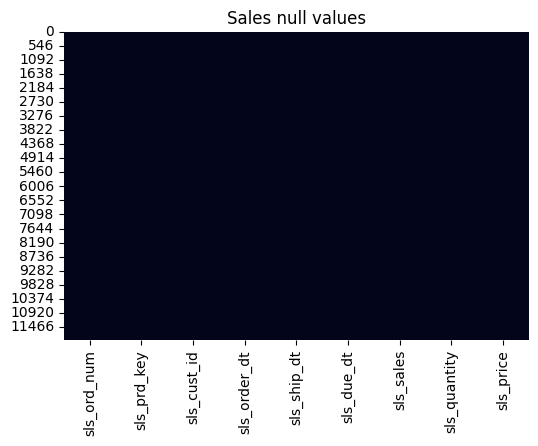

In [156]:
plt.figure(figsize=(6,4))
plt.title('Sales null values')
sns.heatmap(df_sales.isna(),cbar=False)
plt.show()

In [157]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sls_ord_num   11999 non-null  object
 1   sls_prd_key   11999 non-null  object
 2   sls_cust_id   11999 non-null  int64 
 3   sls_order_dt  11999 non-null  int64 
 4   sls_ship_dt   11999 non-null  int64 
 5   sls_due_dt    11999 non-null  int64 
 6   sls_sales     11999 non-null  int64 
 7   sls_quantity  11999 non-null  int64 
 8   sls_price     11999 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 843.8+ KB


In [158]:
#check if the column sls_ord_num contains spaces
df_sales[df_sales['sls_ord_num'].str.contains(' ')]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [159]:
# check id 	sls_order_dt	 is negative or equal to zero
df_sales[df_sales['sls_order_dt'] <=0]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [160]:
# check id 	sls_ship_dt	 is negative or equal to zero
df_sales[df_sales['sls_ship_dt'] <=0]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [162]:
# check id 	sls_due_dt	 is negative or equal to zero
df_sales[df_sales['sls_due_dt'] <=0]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [163]:
# check if the length of sls_order_dt is equal to 8
df_sales[df_sales['sls_order_dt'].astype(str).str.len() == 8].value_counts()

sls_ord_num  sls_prd_key  sls_cust_id  sls_order_dt  sls_ship_dt  sls_due_dt  sls_sales  sls_quantity  sls_price
SO54181      BK-R64Y-40   19386        20130310      20130317     20130322    1120       1             1120         1
SO43697      BK-R93R-62   21768        20101229      20110105     20110110    3578       1             3578         1
SO43698      BK-M82S-44   28389        20101229      20110105     20110110    3400       1             3400         1
SO43699      BK-M82S-44   25863        20101229      20110105     20110110    3400       1             3400         1
SO43700      BK-R50B-62   14501        20101229      20110105     20110110    699        1             699          1
                                                                                                                   ..
SO43731      BK-R93R-56   16629        20110106      20110113     20110118    3578       1             3578         1
SO43732      BK-M82B-44   11025        20110106      20110113

In [164]:
# check if the length of sls_ship_dt is equal to 8
df_sales[df_sales['sls_ship_dt'].astype(str).str.len() == 8].value_counts()

sls_ord_num  sls_prd_key  sls_cust_id  sls_order_dt  sls_ship_dt  sls_due_dt  sls_sales  sls_quantity  sls_price
SO54181      BK-R64Y-40   19386        20130310      20130317     20130322    1120       1             1120         1
SO43697      BK-R93R-62   21768        20101229      20110105     20110110    3578       1             3578         1
SO43698      BK-M82S-44   28389        20101229      20110105     20110110    3400       1             3400         1
SO43699      BK-M82S-44   25863        20101229      20110105     20110110    3400       1             3400         1
SO43700      BK-R50B-62   14501        20101229      20110105     20110110    699        1             699          1
                                                                                                                   ..
SO43731      BK-R93R-56   16629        20110106      20110113     20110118    3578       1             3578         1
SO43732      BK-M82B-44   11025        20110106      20110113

In [165]:
# check if the length of  sls_due_dt is equal to 8
df_sales[df_sales['sls_ship_dt'].astype(str).str.len() == 8].value_counts()

sls_ord_num  sls_prd_key  sls_cust_id  sls_order_dt  sls_ship_dt  sls_due_dt  sls_sales  sls_quantity  sls_price
SO54181      BK-R64Y-40   19386        20130310      20130317     20130322    1120       1             1120         1
SO43697      BK-R93R-62   21768        20101229      20110105     20110110    3578       1             3578         1
SO43698      BK-M82S-44   28389        20101229      20110105     20110110    3400       1             3400         1
SO43699      BK-M82S-44   25863        20101229      20110105     20110110    3400       1             3400         1
SO43700      BK-R50B-62   14501        20101229      20110105     20110110    699        1             699          1
                                                                                                                   ..
SO43731      BK-R93R-56   16629        20110106      20110113     20110118    3578       1             3578         1
SO43732      BK-M82B-44   11025        20110106      20110113

In [166]:
# convert integer values to date
df_sales['sls_order_dt'] = pd.to_datetime(df_sales['sls_order_dt'], format='%Y%m%d',errors='coerce')
df_sales['sls_ship_dt'] = pd.to_datetime(df_sales['sls_ship_dt'], format='%Y%m%d',errors='coerce')
df_sales['sls_due_dt'] = pd.to_datetime(df_sales['sls_due_dt'], format='%Y%m%d',errors='coerce')



In [167]:
df_sales

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price
0,SO43697,BK-R93R-62,21768,2010-12-29,2011-01-05,2011-01-10,3578,1,3578
1,SO43698,BK-M82S-44,28389,2010-12-29,2011-01-05,2011-01-10,3400,1,3400
2,SO43699,BK-M82S-44,25863,2010-12-29,2011-01-05,2011-01-10,3400,1,3400
3,SO43700,BK-R50B-62,14501,2010-12-29,2011-01-05,2011-01-10,699,1,699
4,SO43701,BK-M82S-44,11003,2010-12-29,2011-01-05,2011-01-10,3400,1,3400
...,...,...,...,...,...,...,...,...,...
11994,SO54179,TT-R982,19550,2013-03-10,2013-03-17,2013-03-22,4,1,4
11995,SO54179,RA-H123,19550,2013-03-10,2013-03-17,2013-03-22,120,1,120
11996,SO54180,BK-R64Y-44,19679,2013-03-10,2013-03-17,2013-03-22,1120,1,1120
11997,SO54180,HL-U509,19679,2013-03-10,2013-03-17,2013-03-22,35,1,35


In [169]:
# chek if order date is always before the ship and due date
df_sales[df_sales['sls_order_dt']> df_sales['sls_ship_dt'] ]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [170]:
# chek if order date is always before the sls_due_dt and due date
df_sales[df_sales['sls_order_dt']> df_sales['sls_due_dt']]   

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [171]:
# check if sls_sales is not negative or equal to zero
df_sales[df_sales['sls_sales'] <=0 ]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [172]:
# check if sls_quantity is not negative or equal to zero
df_sales[df_sales['sls_quantity'] <=0 ]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [173]:
# check if the price is negative or equal to 0
df_sales[df_sales['sls_price'] <=0 ]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price
5658,SO51259,WB-H098,11433,2013-01-01,2013-01-08,2013-01-13,10,2,0
5770,SO51298,WB-H098,27949,2013-01-04,2013-01-11,2013-01-16,25,5,0
6018,SO51387,HL-U509-B,11942,2013-01-09,2013-01-16,2013-01-21,70,2,0
6271,SO51479,BC-R205,16687,2013-01-16,2013-01-23,2013-01-28,9,1,0
6273,SO51479,HL-U509,16687,2013-01-16,2013-01-23,2013-01-28,35,1,0
6997,SO51942,BC-M005,11223,2013-01-29,2013-02-05,2013-02-10,100,10,0
7567,SO52187,CL-9009,18110,2013-02-03,2013-02-10,2013-02-15,16,2,0


In [174]:
# calculate the price when it's equal to zero
df_sales['sls_price'] = df_sales.apply(
    lambda row: row['sls_sales'] / row['sls_quantity'] if row['sls_price'] == 0 else row['sls_price'],
    axis=1
)
   

In [175]:
# verify  the price is no longer equal to 0
df_sales[df_sales['sls_price'] <=0 ]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [176]:
# check if sales != quantity * price
df_sales[df_sales['sls_sales'] != df_sales['sls_quantity']*df_sales['sls_price']]

,sls_ord_num,sls_prd_key,sls_cust_id,sls_order_dt,sls_ship_dt,sls_due_dt,sls_sales,sls_quantity,sls_price


In [177]:
# truncate table before inserting records
cur.execute('Truncate table silver.crm_sales  ')
# sql for insert df_products into silver.crm_products
silver_crm_sales_insert="""use DataWarehouse_Demo; INSERT INTO silver.crm_sales (
       sls_ord_num
      ,sls_prd_key
      ,sls_cust_id
      ,sls_order_dt
      ,sls_ship_dt
      ,sls_due_dt
      ,sls_sales
      ,sls_quantity
      ,sls_price
	
    )  
    values(?,?,?,?,?,?,?,?,?) 
"""

In [179]:
try:
    for i , row in df_sales.iterrows():
        cur.execute(silver_crm_sales_insert,list(row))
        con.commit()
    print("Rows inserted successfully !")
except:
    print("Error to insert rows")
finally:
    con.close()
    print('Database closed')

Rows inserted successfully !
Database closed


In [254]:
# ------------------------------------------------------------
#          load bronze.erp_cutomer_info
#--------------------------------------------------------------

In [188]:
# Read the customer_info table from sql server
cur,con = connect_database()
query = "select * from bronze.erp_customer_info;"
df_customer_info = pd.read_sql(query, con)

# Display the DataFrame
df_customer_info 

C:\Users\b.azreg\AppData\Local\Temp\ipykernel_14796\2383987193.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer_info = pd.read_sql(query, con)


,Cid,Bdate,Gen
0,NASAW00011000,1971-10-06 00:00:00,Male
1,NASAW00011001,1976-05-10 00:00:00,Male
2,NASAW00011002,1971-02-09 00:00:00,Male
3,NASAW00011003,1973-08-14 00:00:00,Female
4,NASAW00011004,1979-08-05 00:00:00,Female
...,...,...,...
9994,NASAW00020994,1985-04-21 00:00:00,
9995,NASAW00020995,1984-08-16 00:00:00,
9996,NASAW00020996,1984-09-19 00:00:00,
9997,NASAW00020997,1985-01-06 00:00:00,


In [189]:
# the cid  of customer_info contains the value of cst_key of the table customer plus 3 others characters we have to split cid
df_customer_info['Cid']=df_customer_info['Cid'].str[3:]


In [190]:
df_customer_info.head()

,Cid,Bdate,Gen
0,AW00011000,1971-10-06 00:00:00,Male
1,AW00011001,1976-05-10 00:00:00,Male
2,AW00011002,1971-02-09 00:00:00,Male
3,AW00011003,1973-08-14 00:00:00,Female
4,AW00011004,1979-08-05 00:00:00,Female


In [196]:
# Get today's date 
today = datetime.today().date()

# extract only dat without time
#df_customer_info['Bdate'] = pd.to_datetime(df_customer_info['Bdate'], errors='coerce')
df_customer_info['Bdate'] =df_customer_info['Bdate'].dt.date
# check if bdate is less than today
df_customer_info[df_customer_info['Bdate'] > today]

,Cid,Bdate,Gen
257,AW00011257,2050-07-06,Female
410,AW00011410,2042-02-22,Male
551,AW00011551,2050-05-21,Male
562,AW00011562,2038-10-17,Male
581,AW00011581,2045-03-03,Female
775,AW00011775,2050-11-22,Female
912,AW00011912,2066-06-16,Female
1123,AW00012123,2065-12-12,Male
2417,AW00013417,2050-09-07,Male
9062,AW00020062,2080-03-15,Male


In [200]:
indices_to_drop = df_customer_info[df_customer_info['Bdate'] > today].index

df_customer_info = df_customer_info.drop(indices_to_drop, axis=0)

In [201]:
df_customer_info[df_customer_info['Bdate'] > today]

,Cid,Bdate,Gen


In [202]:
df_customer_info

,Cid,Bdate,Gen
0,AW00011000,1971-10-06,Male
1,AW00011001,1976-05-10,Male
2,AW00011002,1971-02-09,Male
3,AW00011003,1973-08-14,Female
4,AW00011004,1979-08-05,Female
...,...,...,...
9994,AW00020994,1985-04-21,
9995,AW00020995,1984-08-16,
9996,AW00020996,1984-09-19,
9997,AW00020997,1985-01-06,


In [203]:
df_customer_info['Gen'].unique()

array(['Male', 'Female', '  ', ' ', 'M ', 'F ', 'F', 'M', ''],
      dtype=object)

In [204]:
df_customer_info['Gen']=df_customer_info['Gen'].str.strip()
df_customer_info['Gen'].unique()

array(['Male', 'Female', '', 'M', 'F'], dtype=object)

In [205]:
df_customer_info.loc[:, 'Gen'] = df_customer_info['Gen'].replace({'M': 'Male', 'F': 'Female','':'None'})

In [207]:
df_customer_info['Gen'].unique()

array(['Male', 'Female', 'None'], dtype=object)

In [208]:
# truncate table silver.erp_customer_info
con.execute('truncate table silver.erp_customer_info')
# sql for insert df_customer_info into silver.erp_customer_info
silver_erp_customer_info_insert="""USE DataWarehouse_Demo  ; INSERT INTO silver.erp_customer_info(
      Cid ,
      Bdate,
      Gen    
	
    )  
    values(?,?,?) 
"""

In [209]:
try:
    for i , row in df_customer_info.iterrows():
        cur.execute(silver_erp_customer_info_insert,list(row))
        con.commit()
    print("Rows inserted successfully !")
except:
    print("Error to insert rows")
finally:
    con.close()
    print('Database closed')

Rows inserted successfully !
Database closed


In [266]:
#-------------------------------------------------------
#        load bronze.erp_localite
#-----------------------------------------

In [212]:
# Read the customer_info table from sql server
cur,con = connect_database()
query = "select * from bronze.erp_localite;"
df_localite = pd.read_sql(query, con)

# Display the DataFrame
df_localite

C:\Users\b.azreg\AppData\Local\Temp\ipykernel_14796\3650309933.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_localite = pd.read_sql(query, con)


,Cid,Cnt
0,AW-00011000,Australia
1,AW-00011001,Australia
2,AW-00011002,Australia
3,AW-00011003,Australia
4,AW-00011004,Australia
...,...,...
9994,AW-00020994,Australia
9995,AW-00020995,Australia
9996,AW-00020996,Australia
9997,AW-00020997,Australia


In [213]:
# delete the dash from values in Cid column
df_localite['Cid'] = df_localite['Cid'].replace('-', '', regex=True)

In [214]:
df_localite['Cnt'].unique()

array(['Australia', 'US', 'Canada', 'DE', 'United Kingdom', 'France',
       'USA', 'Germany', ''], dtype=object)

In [215]:
# replace US by  united USA DE BY Germany
#df_localite.loc[:, 'cid'] = df_localite['cid'].replace({'US':'USA','DE':'Germany'})
df_localite['Cnt'] = df_localite['Cnt'].replace({'US':'USA','DE':'Germany','':'None'})

In [217]:
df_localite['Cnt'].unique()

array(['Australia', 'USA', 'Canada', 'Germany', 'United Kingdom',
       'France', 'None'], dtype=object)

In [218]:
df_localite

,Cid,Cnt
0,AW00011000,Australia
1,AW00011001,Australia
2,AW00011002,Australia
3,AW00011003,Australia
4,AW00011004,Australia
...,...,...
9994,AW00020994,Australia
9995,AW00020995,Australia
9996,AW00020996,Australia
9997,AW00020997,Australia


In [219]:
# truncate silver.erp_localite
con.execute('truncate table silver.erp_localite')
# sql for insert df_customer_info into silver.erp_customer_info
silver_erp_localite_insert="""USE DataWarehouse_Demo; INSERT INTO silver.erp_localite(
      Cid ,
      Cnt
     )  
    values(?,?) 
"""

In [220]:
try:
    for i , row in df_localite.iterrows():
        cur.execute(silver_erp_localite_insert,list(row))
        con.commit()
    print("Rows inserted successfully !")
except:
    print("Error to insert rows")
finally:
    con.close()
    print('Database closed')

Rows inserted successfully !
Database closed


In [295]:
#---------------------------------------------------------
#       load bronze.erp_category
#---------------------------------------------------------

In [228]:
# Read the category_info table from sql server
cur,con = connect_database()
query = "select * from bronze.erp_category;"
df_category = pd.read_sql(query, con)

# Display the DataFrame
df_category.head()

C:\Users\b.azreg\AppData\Local\Temp\ipykernel_14796\4194777367.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_category = pd.read_sql(query, con)


,ID,Cat,Subcat,Maintenance
0,AC_BR,Accessories,Bike Racks,Yes
1,AC_BS,Accessories,Bike Stands,No
2,AC_BC,Accessories,Bottles and Cages,No
3,AC_CL,Accessories,Cleaners,Yes
4,AC_FE,Accessories,Fenders,No


In [229]:
df_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           37 non-null     object
 1   Cat          37 non-null     object
 2   Subcat       37 non-null     object
 3   Maintenance  37 non-null     object
dtypes: object(4)
memory usage: 1.3+ KB


In [230]:
df_category['Cat'].unique()

array(['Accessories', 'Bikes', 'Clothing', 'Components'], dtype=object)

In [231]:
df_category['Maintenance'].unique()

array(['Yes', 'No'], dtype=object)

In [232]:
# truncate silver.erp_category table
con.execute('truncate table silver.erp_category')
# sql for insert df_customer_info into silver.erp_customer_info
silver_erp_category_insert="""USE DataWarehouse_Demo ; INSERT INTO silver.erp_category(
      ID,
      Cat,
      Subcat,
      Maintenance
     )  
    values(?,?,?,?) 
"""

In [233]:
try:
    for i , row in df_category.iterrows():
        cur.execute(silver_erp_category_insert,list(row))
        con.commit()
    print("Rows inserted successfully !")
except:
    print("Error to insert rows")

Rows inserted successfully !
